In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

def _yxyx_to_xcycwh(box: tf.Tensor):
    """Converts boxes from ymin, xmin, ymax, xmax to x_center, y_center, width, height.
    Args:
        box: a `Tensor` whose last dimension is 4 representing the coordinates of boxes
            in ymin, xmin, ymax, xmax.
    Returns:
        box: a `Tensor` whose shape is the same as `box` in new format.
    """
    with tf.name_scope("yxyx_to_xcycwh"):
        ymin, xmin, ymax, xmax = tf.split(box, 4, axis=-1)
        x_center = (xmax + xmin) / 2
        y_center = (ymax + ymin) / 2
        width = xmax - xmin
        height = ymax - ymin
        box = tf.concat([x_center, y_center, width, height], axis=-1)
    return box

def _xcycwh_to_yxyx(box: tf.Tensor, split_min_max: bool = False):
    """Converts boxes from x_center, y_center, width, height to ymin, xmin, ymax, xmax.
    Args:
        box: a `Tensor` whose last dimension is 4 representing the coordinates of boxes in
            x_center, y_center, width, height.
    Returns:
        box: a `Tensor` whose shape is the same as `box` in new format.
    """
    with tf.name_scope("xcycwh_to_yxyx"):
        xy, wh = tf.split(box, 2, axis=-1)
        xy_min = xy - wh / 2
        xy_max = xy + wh / 2
        box = tf.stack([xy_min[..., 1], xy_min[..., 0], xy_max[..., 1], xy_max[...,0]], axis=-1)
        if split_min_max:
            box = tf.split(box, 2, axis = -1)
    return box

def get_box_area(self, box: tf.Tensor):
    """Returns area of the bounding box.
    Args:
        box: a `Tensor` whose last dimension is 4 representing the coordinates of boxes
            in ymin, xmin, ymax, xmax.
    Returns:
        int: Area covered by the bounding box
    """
    ymin, xmin, ymax, xmax = tf.split(box, 4, axis=-1)
    width = xmax - xmin
    height = ymax - ymin 
    box = tf.concat([width*height, box], axis=-1)
    return box

def random_jitter_boxes(self, boxes: tf.Tensor, box_jitter, seed = 10):
    """Returns the bounding boxes after applying random jitter.
    Args:
        box: a `Tensor` whose last dimension is 4 representing the coordinates of boxes
            in ymin, xmin, ymax, xmax.
        box_jitter: a `float` that is the maximum jitter applied to the bounding
            boxs for data augmentation during training.
        seed: an `int` for the seed used by tf.random when randomly generating jitter amount.
    Returns:
        boxes: randomly jittered bounding boxes.
    """
    num_gen = tf.shape(boxes)[0]
    jx = tf.random.uniform(minval=-box_jitter,
                            maxval=box_jitter,
                            shape=(num_gen, ),
                            seed = seed, 
                            dtype=tf.float32)
    jy = tf.random.uniform(minval=-box_jitter,
                            maxval=box_jitter,
                            shape=(num_gen, ),
                            seed = seed, 
                            dtype=tf.float32)
    jw = tf.random.uniform(minval=-box_jitter,
                            maxval=box_jitter,
                            shape=(num_gen, ),
                            seed = seed, 
                            dtype=tf.float32)+1
    jh = tf.random.uniform(minval=-box_jitter,
                            maxval=box_jitter,
                            shape=(num_gen, ),
                            seed = seed, 
                            dtype=tf.float32)+1
    #tf.print(tf.math.reduce_sum(jx))
    boxes = _jitter_boxes(boxes, jx, jy, jw, jh)
    return boxes
  
def _jitter_boxes(box, j_cx, j_cy, j_w, j_h):
    """Jitter the bounding boxes with the specified amounts.
    Args:
        box: a `Tensor` whose last dimension is 4 representing the coordinates of boxes
            in ymin, xmin, ymax, xmax.
        j_cx: a `float` that is the jitter applied to the x coordinate of the center of 
            bounding boxes.
        j_cy: a `float` that is the jitter applied to the y coordinate of the center of 
            bounding boxes.
        j_w: a `float` that is the jitter applied to the width of bounding boxes.
        j_h: a `float` that is the jitter applied to the height of bounding boxes.
    Returns:
        boxes: the bounding boxes after being jittered as the specified amount
    """
    with tf.name_scope("jitter_boxs"):
        x = tf.clip_by_value(tf.math.add(box[..., 0], j_cx), clip_value_min=0.0, clip_value_max=1.0)
        y = tf.clip_by_value(tf.math.add(box[..., 1], j_cy), clip_value_min=0.0, clip_value_max=1.0)
        w = box[..., 2] * j_w
        h = box[..., 3] * j_h
        box = tf.stack([x, y, w, h], axis = -1)
        box.set_shape([None, 4])
    return box

def random_flip(image, box, seed = 10):
    """Apply random horizontal flip on the image and the bounding boxes.
    Args:
        image: the image tensor.
        box: a `Tensor` whose last dimension is 4 representing the coordinates of boxes
            in ymin, xmin, ymax, xmax.
        seed: an `int` for the seed used by tf.random when randomly generating the vertical axis for flipping.
    Returns:
        image: randomly flipped image
        boxes: randomly flipped bounding boxes
    """
    do_flip_x = tf.greater(tf.random.uniform([], seed=seed), 0.5)
    x = box[..., 0]
    y = box[..., 1]
    if do_flip_x:
        image = tf.image.flip_left_right(image)
        x = 1 - x
    return image, tf.stack([x, y, box[..., 2], box[..., 3]], axis = -1)
  
def pad_max_instances(value, instances, pad_value = 0):
    """Padds the `value` tensor with ones if the number of instances in this tensor is less than `instance`.
    Args:
        value: a `Tensor` to be padded
        instances: an `int` for the number of instances
    Returns:
        value: the padded tensor
    """
    shape = tf.shape(value)
    dim1 = shape[0]

    if dim1 > instances: 
        value = value[:instances, ...]
        return value
    else: 
        nshape = tf.tensor_scatter_nd_update(shape, [[0]], [instances - dim1])# 
        pad_tensor = tf.ones(nshape, dtype=value.dtype) * pad_value
        value = tf.concat([value, pad_tensor], axis = 0)
        return value 


In [ ]:
import abc
from typing import Callable

class Parser(object):
    """Parses data and produces tensors to be consumed by models."""

    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def _parse_train_data(self, decoded_tensors):
        """Generates images and labels that are usable for model training.
        Args:
            decoded_tensors: a dict of Tensors produced by the decoder.
        Returns:
            images: the image tensor.
            labels: a dict of Tensors that contains labels.
        """
        pass

    @abc.abstractmethod
    def _parse_eval_data(self, decoded_tensors):
        """Generates images and labels that are usable for model evaluation.
        Args:
            decoded_tensors: a dict of Tensors produced by the decoder.
        Returns:
            images: the image tensor.
            labels: a dict of Tensors that contains labels.
        """
        pass

    def parse_fn(self, is_training):
        """Returns a parse fn that reads and parses raw tensors from the decoder.
        Args:
            is_training: a `bool` to indicate whether it is in training mode.
        Returns:
            parse: a `callable` that takes the serialized examle and generate the
                images, labels tuple where labels is a dict of Tensors that contains
                labels.
        """
        def parse(decoded_tensors):
            """Parses the serialized example data."""
            if is_training:
                return self._parse_train_data(decoded_tensors)
            else:
                return self._parse_eval_data(decoded_tensors)
        return parse

In [ ]:
def build_gridded_gt_v1(y_true: dict, num_classes: int, size: int,
                        num_boxes: int, dtype=tf.float64) -> tf.Tensor:
    """
    Convert ground truth for use in loss functions.
    Args:
        y_true: dict[tf.Tensor] containing 'bbox':boxes, 'label':classes
        num_classes: number of classes
        size: dimensions of grid S*S
        dtype: type of float
        num_boxes: number of boxes in each grid
    Return:
        tf.Tensor[batch, size, size, num_boxes, num_classes + 5]
    """
    boxes = tf.cast(y_true["bbox"], dtype)  # [xcenter, ycenter, width, height]
    classes = tf.one_hot(tf.cast(y_true["label"], dtype=tf.int32),
                         depth=num_classes, dtype=dtype)
    batches = boxes.get_shape().as_list()[0]
    gt_boxes = boxes.get_shape().as_list()[1]
    full = tf.zeros([batches, size, size, num_boxes,
                     num_classes + 4 + 1], dtype=dtype)
    # x centered coords
    x = tf.cast(boxes[..., 0] * tf.cast(size, dtype=dtype), dtype=tf.int32)
    # y centered coords
    y = tf.cast(boxes[..., 1] * tf.cast(size, dtype=dtype), dtype=tf.int32)
    i = 0  # index for tensor array
    full_confidence = tf.cast(tf.convert_to_tensor([1.]), dtype=dtype)
    update_index = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    update = tf.TensorArray(dtype, size=0, dynamic_size=True)

    tf.print(boxes)
    for batch in range(batches):
        for box_id in range(gt_boxes):
            if tf.math.reduce_all(tf.math.equal(boxes[batch, box_id, 2:4], 0),
                                  axis=None):
                continue
            if tf.math.reduce_any(tf.math.less(
                                  boxes[batch, box_id, 0:2], 0.0)):
                continue
            if tf.math.reduce_any(tf.math.greater_equal(
                                  boxes[batch, box_id, 0:2], 1.0)):
                continue
            for n in range(num_boxes):
                # index for box in the output [batch, x, y, box number]
                update_index = update_index.write(i,
                                                  [batch,
                                                   y[batch, box_id],
                                                   x[batch, box_id], n])
                # value of box to be updated: [x, y, w, h, confidence, classes]
                value = tf.concat([boxes[batch, box_id],
                                   full_confidence,
                                   classes[batch, box_id]],
                                  -1)
                update = update.write(i, value)
                i += 1
    # if no updates, return empty grid
    if tf.math.greater(update_index.size(), 0):
        update_index = update_index.stack()
        update = update.stack()
        full = tf.tensor_scatter_nd_add(full, update_index, update)
    return full

In [ ]:
def compute_iou(box1, box2):
    # get box corners
    with tf.name_scope("iou"):
        box1 = _xcycwh_to_xyxy(box1)
        box2 = _xcycwh_to_xyxy(box2)
        intersection, union = _intersection_and_union(box1, box2)

        iou = tf.math.divide_no_nan(intersection, union)
        iou = tf.clip_by_value(iou, clip_value_min=0.0, clip_value_max=1.0)
    return iou


def compute_giou(box1, box2):
    with tf.name_scope("giou"):
        # get box corners
        box1 = _xcycwh_to_xyxy(box1)
        box2 = _xcycwh_to_xyxy(box2)

        # compute IOU
        intersection, union = _intersection_and_union(box1, box2)
        iou = tf.math.divide_no_nan(intersection, union)
        iou = tf.clip_by_value(iou, clip_value_min=0.0, clip_value_max=1.0)

        # find the smallest box to encompase both box1 and box2
        c_mins = K.minimum(box1[..., 0:2], box2[..., 0:2])
        c_maxes = K.maximum(box1[..., 2:4], box2[..., 2:4])
        c = _get_area((c_mins, c_maxes), use_tuple=True)

        # compute giou
        giou = iou - tf.math.divide_no_nan((c - union), c)
    return iou, giou


def compute_diou(box1, box2):
    with tf.name_scope("diou"):
        # compute center distance
        dist = _center_distance(box1[..., 0:2], box2[..., 0:2])

        # get box corners
        box1 = _xcycwh_to_xyxy(box1)
        box2 = _xcycwh_to_xyxy(box2)

        # compute IOU
        intersection, union = _intersection_and_union(box1, box2)
        iou = tf.math.divide_no_nan(intersection, union)
        iou = tf.clip_by_value(iou, clip_value_min=0.0, clip_value_max=1.0)

        # compute max diagnal of the smallest enclosing box
        c_mins = K.minimum(box1[..., 0:2], box2[..., 0:2])
        c_maxes = K.maximum(box1[..., 2:4], box2[..., 2:4])
        diag_dist = _center_distance(c_mins, c_maxes)

        regularization = tf.math.divide_no_nan(dist, diag_dist)
        diou = iou + regularization
    return iou, diou


def compute_ciou(box1, box2):
    with tf.name_scope("ciou"):
        #compute DIOU and IOU
        iou, diou = compute_diou(box1, box2)

        # computer aspect ratio consistency
        v = _aspect_ratio_consistancy(box1[..., 2], box1[..., 3], box2[..., 2],
                                      box2[..., 3])

        # compute IOU regularization
        a = v / ((1 - iou) + v)
        ciou = diou + v * a
    return iou, ciou

In [ ]:
class Yolo_Loss_v1(tf.keras.losses.Loss):
    def __init__(self,
                 coord_scale=5.0,
                 noobj_scale=0.5,
                 num_boxes=2,
                 num_classes=20,
                 size=7,
                 ignore_thresh=0.7,
                 reduction=tf.keras.losses.Reduction.NONE,
                 name=None,
                 **kwargs):
        """
        Detection loss function parameters (YOLO v1)
        Args: 
            coord_scale: float indicating the weight on the localization loss
            noobj_scale: float indicating the weight on the confidence loss
            num_boxes: integer, number of prediction boxes per grid cell 
            num_classes: integer, number of class probabilities each box predicts
            size: integer, specifying that the input has size * size grid cells
            ignore_thresh: float indicating the confidence threshold of whether a box
                           contains an object within it.
        call Return: 
            float: for the average loss 
        """
        super(Yolo_Loss_v1, self).__init__(reduction=reduction,
                                           name=name,
                                           **kwargs)
        self._coord_scale = coord_scale
        self._noobj_scale = noobj_scale
        self._num_boxes = num_boxes
        self._num_classes = num_classes
        self._ignore_thresh = ignore_thresh
        self._size = size

        # metrics
        self._localization_loss = 0.0
        self._confidence_loss = 0.0
        self._classification_loss = 0.0
        
    
    def call(self, y_true, y_pred):
        y_true = build_gridded_gt_v1(y_true=y_true, num_classes=self._num_classes, size=self._size);
        class_start = self._num_boxes * 5

        # Seperate bounding box components from class probabilities
        pred_boxes = y_pred[..., :class_start]
        pred_class = y_pred[..., class_start:]

        true_boxes = y_true[..., :class_start]
        true_class = y_true[..., class_start:]

        # Get components from the box
        pred_class = tf.reshape(pred_class, [-1, 1, self._num_classes])
        true_class = tf.reshape(true_class, [-1, 1, self._num_classes])
        pred_boxes = tf.reshape(pred_boxes, [-1, self._num_boxes, 5])
        true_boxes = tf.reshape(true_boxes, [-1, self._num_boxes, 5])

        pred_boxes_xywh = pred_boxes[..., 0:4] 
        pred_xy = pred_boxes_xywh[..., 0:2]
        pred_wh = pred_boxes_xywh[..., 2:4]
        pred_confidence = pred_boxes[..., 4]

        true_boxes_xywh = true_boxes[..., 0:4] 
        true_xy = true_boxes_xywh[..., 0:2]
        true_wh = true_boxes_xywh[..., 2:4]
        true_confidence = true_boxes[..., 4]

        # Reparameterization:
        shape = y_pred.get_shape()
        width, height = shape[1], shape[2]

        pred_xy = pred_xy / [width, height]
        pred_wh = pred_wh / [width, height]
        pred_class = tf.keras.activations.softmax(true_class, axis=-1)

        # Determine IOU of all predictor boxes vs gt boxes in each cell
        iou = compute_iou(true_boxes_xywh, pred_boxes_xywh)

        # Mask off the non-predictor bounding boxes based on iou
        predictor_mask = self.get_predictor_mask(iou)
        # Mask off cells not detecting objects
        ignore_object_mask = self.get_ignore_object_mask(iou)

        # Localization loss:
        loss_xy = tf.reduce_sum(tf.math.square(true_xy - pred_xy), axis=-1) * predictor_mask * true_confidence
        loss_wh = tf.reduce_sum(tf.math.square(tf.math.sqrt(true_wh) -
                                tf.math.sqrt(pred_wh)), axis=-1) * predictor_mask * true_confidence

        localization_loss = self._coord_scale * (tf.reduce_mean(loss_xy + loss_wh))

        # Confidence loss:
        obj_loss = tf.math.square(true_confidence - 
                                  pred_confidence) * predictor_mask * true_confidence
        noobj_loss = tf.math.square(true_confidence - 
                                    pred_confidence) * (1 - predictor_mask) * (1 - true_confidence)
        
        confidence_loss = tf.reduce_mean(obj_loss + self._noobj_scale * noobj_loss)

        # Class Probability loss:
        classification_loss = tf.reduce_sum(tf.math.square(true_class - 
                                                           pred_class), axis=-1) * ignore_object_mask * true_confidence

        classification_loss = tf.reduce_mean(classification_loss)
        
        # Update metrics:
        self._localization_loss = localization_loss
        self._confidence_loss = confidence_loss
        self._classification_loss = classification_loss

        # Final loss:
        return localization_loss + confidence_loss + classification_loss
    
    def get_predictor_mask(self, iou):
        """
        Generates a mask for each cell indicating which box among the predictions should
        be used when computing localization and confidence loss.
        The predictor mask is generated by finding the argmax of the prediction box to ground
        truth IOU. In the case of ties, the smallest index is chosen due to nature of tf.math.argmax
        Args: 
            iou: Tensor of shape [num_cells, num_boxes] denoting the iou of each box compared to the
                 ground truth of each cell
        Return: 
            Tensor of shape [num_cells, num_boxes] denoting the boxes to be used as predictors
        """
        shape = iou.get_shape().as_list()
        num_cells = shape[0]
        num_boxes = shape[1]

        predictor_mask = []
        for i in range(num_cells):
            max_iou_idx = tf.math.argmax(iou[i])
            mask_val = [0] * num_boxes
            mask_val[max_iou_idx] = 1
            predictor_mask.append(tf.convert_to_tensor(mask_val, dtype=tf.float32))

        return tf.stack(predictor_mask)

    # NOTE: OLD PREDICTOR MASK GENERATOR
    # def get_predictor_mask(self, iou, penalize_miss=False):
    #     # If penalize_miss is True, then if both bounding box iou's are 0
    #     # (ie. both bounding boxes completely miss the ground truth box),
    #     # then both boxes are considered in the loss
    
    #     highest_iou = tf.reduce_max(iou, axis=-1, keepdims=True)
    #     if penalize_miss:
    #         # The box with the highest iou is assigned 1, the other 0
    #         # If both boxes have iou 0 or tie, they are both assigned 1 
    #         highest_iou_mask = iou >= highest_iou
    #     else:
    #         # The box with the highest iou is assigned 1, the other 0
    #         # If both boxes have iou 0, they are both assigned 0. If they
    #         # are not 0 and tie, then they are both assigned 1
    #         highest_iou_mask = tf.math.divide_no_nan(iou, highest_iou)
    #         highest_iou_mask = highest_iou_mask >= 1
        
    #     return tf.cast(highest_iou_mask, dtype=tf.float32)

    def get_ignore_object_mask(self, iou):
        """
        Generates a mask for each cell whether either bounding box prediction detects an object
        The mask is generated by determining if either of the prediction-ground truth box iou
        exceeds self._ignore_thresh. If so, it is assigned 1 otherwise 0.
        Args: 
            iou: Tensor of shape [num_cells, num_boxes] denoting the iou of each box compared to the
                 ground truth of each cell
        Return: 
            Tensor of shape [num_cells, 1] denoting whether an object appears in the cell
        """
        highest_iou = tf.reduce_max(iou, axis=-1, keepdims=True)
        ignore_object_mask = highest_iou >= self._ignore_thresh

        return tf.cast(ignore_object_mask, tf.float32)

In [ ]:
 """Detection parser."""

# Import libraries

class Detection_Parser(Parser):
    """Parser to parse an image and its annotations into a dictionary of tensors."""
    def __init__(self,
                 output_size,
                 num_classes = 80,
                 random_flip = True,
                 max_num_instances = 100,
                 seed=10,
                 dtype='float32',
                 jitter=.05,
                 aug_rand_brightness= True,
                 aug_rand_saturation = True,
                 aug_rand_hue = True): 
        """Initializes parameters for parsing annotations in the dataset.
        Args:
            output_size: `Tensor` or `list` for [height, width] of output image. The
                output_size should be divided by the largest feature stride 2^max_level.
            num_classes: `float`, number of classes.
            random_flip: `boolean` value that indicates whether the random flip operation
                will be applied.
            max_num_instances: an `int` number of maximum number of instances in an image.
            seed: an `int` for the seed used by tf.random.
            dtype: a `string` that indicates the datatype.
            jitter_boxes: a `float` that is the maximum jitter applied to the bounding
                box for data augmentation during training.
            aug_rand_brightness: `bool`, if True, augment training with random 
                brightness.
            aug_rand_saturation: `bool`, if True, augment training with random
                saturation.
            aug_rand_hue: `bool`, if True, augment training with random
                hue.
        """
        self._output_size = output_size
        self._num_classes = num_classes
        self._random_flip = random_flip
        self._max_num_instances = max_num_instances
        self._seed = seed
        self._jitter = jitter
        self._aug_rand_brightness = aug_rand_brightness
        self._aug_rand_saturation = aug_rand_saturation
        self._aug_rand_hue = aug_rand_hue
        if dtype == 'float32':
            self._dtype = tf.float32
        elif dtype == 'float16':
            self._dtype = tf.float16
        elif dtype == 'bfloat16':
            self._dtype = tf.bfloat16
        else:
            raise ValueError('dtype {!r} is not supported!'.format(dtype))

    def _parse_train_data(self, decoded_tensors):
        """Generates images and labels that are usable for model training.
            Args:
                decoded_tensors: a dict of Tensors produced by the decoder.
            Returns:
                images: the image tensor.
                labels: a dict of Tensors that contains labels.
        """
        #Define image and boxes
        image = tf.cast(decoded_tensors['image'], tf.float32)
        w = tf.cast(tf.shape((image)[0], tf.int32), dtype=tf.float32)
        h = tf.cast(tf.shape((image)[1], tf.int32), dtype= tf.float32)
        image = tf.image.resize(image, size = [608,608])

        #Sort Boxes by Area
        boxes = decoded_tensors['objects']['bbox']
        #sort by concatenate extra "area" vector 
        boxes = get_box_area(self, boxes)
        index = tf.argsort(boxes[..., 0], axis=0, direction='DESCENDING')
        boxes = tf.gather(boxes, index, axis = 0)

        #subset to get boxes of original dim. in sorted order 
        boxes = boxes[..., 1:]

        #Center Box coordinates - xmin,ymin,xmax,ymax to xcenter,ycenter,w,h
        boxes = _yxyx_to_xcycwh(boxes)

        # #Jitter Bounding Boxes
        if self._jitter != 0.0:
            boxes = random_jitter_boxes(self, boxes, box_jitter = self._jitter, seed = self._seed)

        #Data Augmentation Steps (Image Specific)
        if self._aug_rand_brightness: 
            image = tf.image.random_brightness(image = image, max_delta = 0.1) #brightness
        if self._aug_rand_saturation: 
            image = tf.image.random_saturation(image = image, lower = 0.75, upper = 1.5) #saturation
        if self._aug_rand_hue: 
            image = tf.image.random_hue(image = image, max_delta = 0.1) #hue
        image = image / 255 #normalize
        image = tf.clip_by_value(image, 0, 1)
        image = tf.cast(image, self._dtype)


        #Data Augmentation Steps (Bounding Box Specific)
        if self._random_flip:
            image, boxes = random_flip(image, boxes, seed = self._seed)

        #Padding
        boxes = pad_max_instances(boxes, self._max_num_instances, 0)
        classes = pad_max_instances(decoded_tensors['objects']['label'], self._max_num_instances, -1)
        
        labels = {
            "source_id": decoded_tensors['image/filename'],
            "bbox": boxes,
            "label": self._num_classes,
            "width": w,
            "height": h,
            "num_detections": tf.shape(decoded_tensors['objects']['label'])[0],
        }         

        if "objects" in decoded_tensors:
            return image, labels
        else:
            return image, tf.one_hot(decoded_tensors['label'],
                                     self._num_classes)

    def _parse_eval_data(self, decoded_tensors):
        """Generates images and labels that are usable for model evaluation.
        Args:
            decoded_tensors: a dict of Tensors produced by the decoder.
        Returns:
            images: the image tensor.
            labels: a dict of Tensors that contains labels.
        """
        
        image = tf.cast(decoded_tensors['image'], tf.float32)
        w = tf.cast(tf.shape((image)[0], tf.int32), dtype=tf.float32)
        h = tf.cast(tf.shape((image)[1], tf.int32), dtype= tf.float32)
        image = tf.image.resize_with_pad(
            image,
            target_width=self._output_size[0],
            target_height=self._output_size[1])  # Final Output Shape
        boxes = decoded_tensors['objects']['bbox']
        image = image / 255 #normalize
        image = tf.clip_by_value(image, 0, 1)
        image = tf.cast(image, self._dtype)
        labels = {
            "source_id": decoded_tensors['image/filename'],
            "bbox": boxes,
            "label": self._num_classes,
            "width": w,
            "height": h,
            "num_detections": tf.shape(decoded_tensors['objects']['label'])[0],
        } 

        if "objects" in decoded_tensors:
            return image, labels
        else:
            return image, tf.one_hot(decoded_tensors['label'],
                                     self._num_classes)

    

In [ ]:
def preprocessing(dataset, num_classes, batch_size, size, data_augmentation_split = 100, preprocessing_type = "detection", shuffle_flag = False):
    """A testing function for the detection pipeline of YOLO v1.
    Args:
    Returns:
    """
    data_augmentation_split = int((data_augmentation_split/100)*size)
    non_preprocess_split = size-data_augmentation_split
    data_augmentation_dataset = dataset.take(data_augmentation_split)
    remaining = dataset.skip(data_augmentation_split)
    non_preprocess_split = remaining.take(non_preprocess_split)
    if (preprocessing_type.lower() == "detection"):
        Dataset_Parser = Detection_Parser([224,224],50)
        _normalize, _data_augmentation = Dataset_Parser.parse_fn(is_training = False), Dataset_Parser.parse_fn(is_training = True)
        non_preprocess_split = non_preprocess_split.map(_normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        data_augmentation_dataset = data_augmentation_dataset.map(_data_augmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = data_augmentation_dataset.concatenate(non_preprocess_split)
        if shuffle_flag == True:
            dataset = dataset.shuffle(size)
        dataset = dataset.padded_batch(int(batch_size)).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
tfds.core.Version("2.3.1")
Train, Info = tfds.load("voc/2007", split = "train", with_info = True)
Size = int(Info.splits['train'].num_examples)

print("done")


Done2






__________>>>>>>>>>>>> [[[0.375883132 0.523149073 0.707633257 0.798844576]
  [0.39042291 0.328758359 0.352721542 0.41871196]
  [0.636227489 0.718066573 0.239466414 0.251874894]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0.402444452 0.436444491 0.70011735 0.775357664]
  [0.192510366 0.566843688 0.30319798 0.454448462]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0.456293404 0.672706544 1.03446245 0.765960097]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0.52663064 0.535045505 0.935117185 0.918354]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0.649966717 0.561609864 0.380222857 0.60935986]
  [0.296803713 0.728905 0.320341587 0.361511022]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0.573310614 0.79368937 0.151453406 0.199245363]
  [0.285098493 0.684234798 0.0941068754 0.130931407]
  [0.273802936 0.64286375 0.0972197205 0.0959234387]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


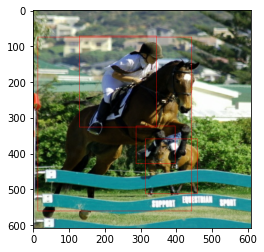

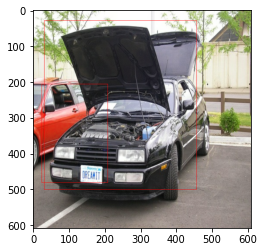

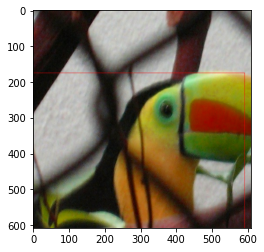

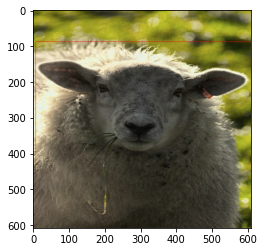

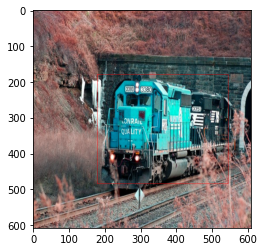

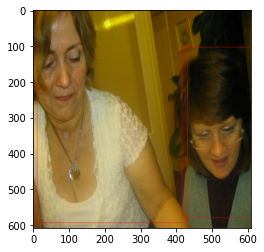

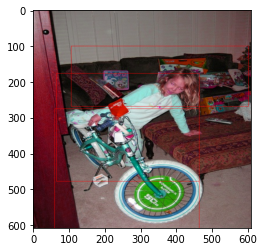

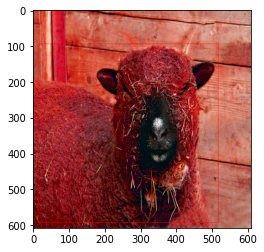

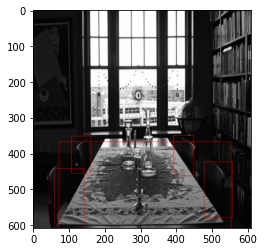

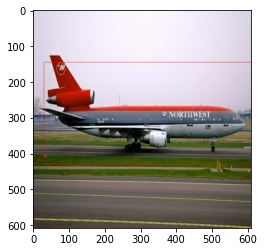

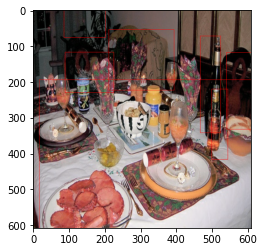

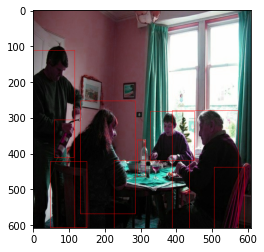

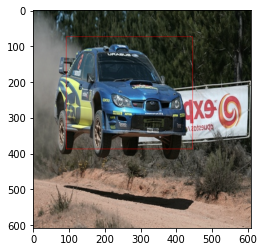

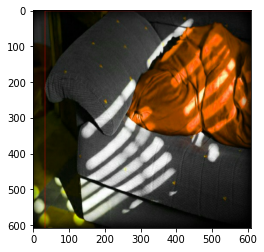

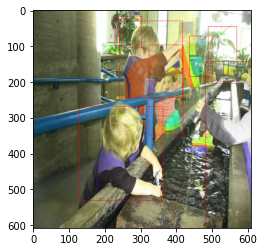

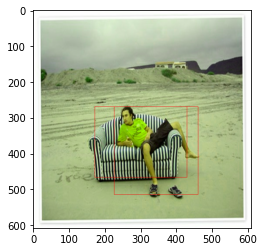

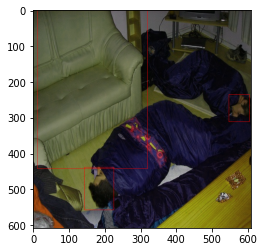

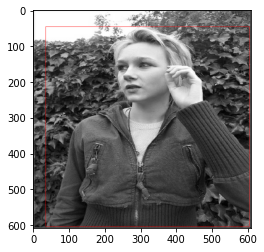

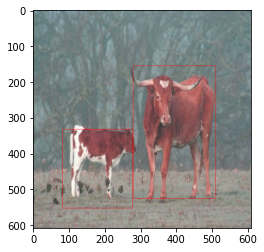

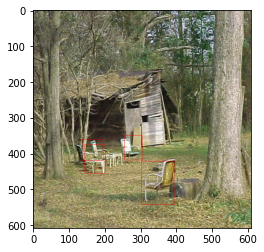

total time: 5.7189531326293945
num_img: 1
size: 2501


In [ ]:
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

Train = preprocessing(Train, 3, 20, Size, data_augmentation_split = 100, preprocessing_type = "detection", shuffle_flag = False)

start = time.time()
count = 0
print("Done2")
train_ds = Train.take(1)
#tf.print(train_ds)


for datapoint in train_ds:
    image, labels = datapoint
    boxes = labels['bbox']
    tf.print("\n\n\n\n\n\n__________>>>>>>>>>>>>" , boxes)
    boxes = _xcycwh_to_yxyx(boxes)
    image = tf.image.draw_bounding_boxes(image, boxes, [[1.0, 0.0, 0.0]])
    for im in image:
        plt.imshow(im.numpy())
        plt.show()

    arr = image
    count += 1

end = time.time()
print(f'total time: {end-start}')
print(f'num_img: {count}')
print(f'size: {Size}')